### 导入库

In [1]:
import torch
from torch.utils import data
import torchvision
from torchvision import transforms
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

from data import LoadData
from model import VGG16
from utils import *
from loss import EdgeHoldLoss

for name in (torch, torchvision, cv2, np):
    print(name.__version__)

1.6.0+cu101
0.7.0+cu101
4.3.0
1.19.1


### 使用GPU或者CPU

In [2]:
if torch.cuda.is_available():
    device = torch.device(device='cuda')
else:
    device = torch.device(device='cpu')
device

device(type='cuda')

In [3]:
path_image = "./DUTS/DUTS-TR/DUTS-TR-Image/"
path_mask = "./DUTS/DUTS-TR/DUTS-TR-Mask/"

In [4]:
batch_size = 4 #受限于贫穷，3是极限了
learning_rate = 0.000156
target_size = 256
epochs = 5

In [5]:
data_loader = data.DataLoader(LoadData(path_image, path_mask, target_size),
                            batch_size=batch_size,
                            shuffle=True)

In [6]:
total_batch = len(data_loader)
total_batch

2639

### 导入模型

In [7]:
model = VGG16()

In [8]:
model.load_state_dict(torch.load("./model/MPFA_30.pth"), strict=False)

<All keys matched successfully>

In [9]:
model.eval()
model.to(device)
criterion = EdgeHoldLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0, momentum=0.9)

In [10]:
for epoch in range(epochs):
    start_time = time.time()
    model.train()
    
    total_loss = 0
    total_acc = 0
    total_pre = 0
    total_rec = 0
    total_f_score = 0
    
    for batch_n, (image, mask) in enumerate(data_loader, start=1):
        
        image = image.to(device)
        mask = mask.to(device)
        
        optimizer.zero_grad()
        predict = model(image)
        loss = criterion(predict, mask)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            total_loss += loss.item()
            acc = accuracy(predict, mask)
            total_acc += acc

            pre = precision(predict, mask)
            total_pre += pre

            rec = recall(predict, mask)
            total_rec += rec

            f_score = F_Measure(pre, rec)
            total_f_score += f_score
        
        
        if batch_n % 100 == 0:
            with torch.no_grad():
                avg_acc = total_acc / batch_n
                avg_pre = total_pre / batch_n
                avg_rec = total_rec / batch_n
                avg_f_score = total_f_score / batch_n
                print("Epoch:{} loss:{} Batch:{}/{}".format(epoch + 1, loss.item(), batch_n, total_batch), end="")
                print(" acc:{} pre:{} recall:{} F-measure:{}"
                      .format(avg_acc, avg_pre, avg_rec, avg_f_score))
    end_time = time.time()
    print("--------------------------------------------------------------")
    print("Epoch {} time:{:.2f}s END :loss:{} acc:{} pre:{} rec:{} F-measure:{}"
          .format(epoch + 1, 
                  end_time - start_time,
                  total_loss / total_batch, 
                  total_acc / total_batch,
                  total_pre / total_batch,
                  total_rec / total_batch,
                  total_f_score / total_batch))
    print("--------------------------------------------------------------")

Epoch:1 loss:0.38635385036468506 Batch:100/2639 acc:0.9205232262611389 pre:0.9342946410179138 recall:0.8941373825073242 F-measure:0.9232009649276733
Epoch:1 loss:0.3921346068382263 Batch:200/2639 acc:0.9227220416069031 pre:0.9297124743461609 recall:0.8981497287750244 F-measure:0.9206821918487549
Epoch:1 loss:0.380254864692688 Batch:300/2639 acc:0.9239740967750549 pre:0.9337731003761292 recall:0.8957476019859314 F-measure:0.9232388734817505
Epoch:1 loss:0.3907102346420288 Batch:400/2639 acc:0.9240975975990295 pre:0.9342861175537109 recall:0.8951298594474792 F-measure:0.9233025312423706
Epoch:1 loss:0.39180076122283936 Batch:500/2639 acc:0.9236270785331726 pre:0.9354529976844788 recall:0.8952966332435608 F-measure:0.92423415184021
Epoch:1 loss:0.3868507146835327 Batch:600/2639 acc:0.9234237670898438 pre:0.9360866546630859 recall:0.893251359462738 F-measure:0.9240593910217285
Epoch:1 loss:0.3756607174873352 Batch:700/2639 acc:0.923450231552124 pre:0.9359501600265503 recall:0.8930577039718

Epoch:3 loss:0.3754383325576782 Batch:100/2639 acc:0.9221423864364624 pre:0.9399943351745605 recall:0.8992034792900085 F-measure:0.9290314316749573
Epoch:3 loss:0.3866579532623291 Batch:200/2639 acc:0.9219853281974792 pre:0.9401324391365051 recall:0.8946359753608704 F-measure:0.9276861548423767
Epoch:3 loss:0.3871791362762451 Batch:300/2639 acc:0.9226123094558716 pre:0.9399009346961975 recall:0.8922327160835266 F-measure:0.9270040392875671
Epoch:3 loss:0.3793468177318573 Batch:400/2639 acc:0.9231551885604858 pre:0.9408075213432312 recall:0.8939352035522461 F-measure:0.9281707406044006
Epoch:3 loss:0.3721187114715576 Batch:500/2639 acc:0.9230591058731079 pre:0.943522572517395 recall:0.8944976329803467 F-measure:0.9303731918334961
Epoch:3 loss:0.3758125901222229 Batch:600/2639 acc:0.9232620596885681 pre:0.9420600533485413 recall:0.8973764181137085 F-measure:0.9299357533454895
Epoch:3 loss:0.37785670161247253 Batch:700/2639 acc:0.9233492612838745 pre:0.9411550164222717 recall:0.8958743810

Epoch:5 loss:0.3838174045085907 Batch:100/2639 acc:0.9189683198928833 pre:0.946884036064148 recall:0.8883138298988342 F-measure:0.9306786060333252
Epoch:5 loss:0.37713736295700073 Batch:200/2639 acc:0.9211631417274475 pre:0.9378646016120911 recall:0.8912858963012695 F-measure:0.9247652888298035
Epoch:5 loss:0.37936705350875854 Batch:300/2639 acc:0.9225138425827026 pre:0.9395901560783386 recall:0.8930763006210327 F-measure:0.9265746474266052
Epoch:5 loss:0.3885888159275055 Batch:400/2639 acc:0.9233188629150391 pre:0.9397544860839844 recall:0.8951085209846497 F-measure:0.9273529648780823
Epoch:5 loss:0.3824002742767334 Batch:500/2639 acc:0.9237724542617798 pre:0.9392967820167542 recall:0.8977375030517578 F-measure:0.9277933835983276
Epoch:5 loss:0.38898611068725586 Batch:600/2639 acc:0.9236544966697693 pre:0.9397732615470886 recall:0.897473156452179 F-measure:0.9280704855918884
Epoch:5 loss:0.38670945167541504 Batch:700/2639 acc:0.9238502383232117 pre:0.93896484375 recall:0.8977621793746

In [11]:
torch.save(model.state_dict(),"./model/MPFA_35.pth")

In [12]:
def pad_resize_image(inp_img, out_img=None, target_size=None):
    h, w, c = inp_img.shape
    size = max(h, w)

    padding_h = (size - h) // 2
    padding_w = (size - w) // 2

    if out_img is None:
        # For inference
        temp_x = cv2.copyMakeBorder(inp_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        if target_size is not None:
            temp_x = cv2.resize(temp_x, (target_size, target_size), interpolation=cv2.INTER_AREA)
        return temp_x
    else:
        # For training and testing
        temp_x = cv2.copyMakeBorder(inp_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        temp_y = cv2.copyMakeBorder(out_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        # print(inp_img.shape, temp_x.shape, out_img.shape, temp_y.shape)

        if target_size is not None:
            temp_x = cv2.resize(temp_x, (target_size, target_size), interpolation=cv2.INTER_AREA)
            temp_y = cv2.resize(temp_y, (target_size, target_size), interpolation=cv2.INTER_AREA)
        return temp_x, temp_y


In [13]:
def getInput(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype('float32')
    
    img = pad_resize_image(img, target_size=256)
    img /= 255.
    img = np.transpose(img, axes=(2, 0, 1))
    img = torch.from_numpy(img).float()
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]) 
    
    img = normalize(img)
    return img

In [14]:
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

In [15]:
msk.shape

torch.Size([256, 256, 1])

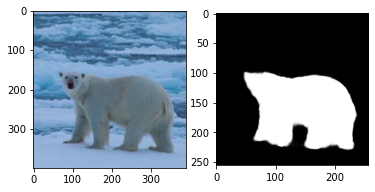

In [16]:
img = getInput("./image/1.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk, cmap='gray')
plt.show()

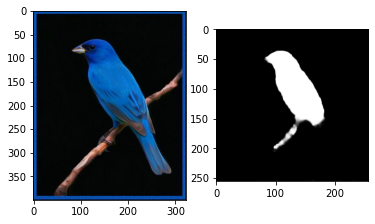

In [17]:
img = getInput("./image/2.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/2.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk, cmap='gray')
plt.show()

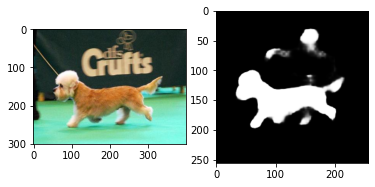

In [18]:
img = getInput("./image/3.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/3.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk, cmap='gray')
plt.show()